In [6]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from functions import *

In [338]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [337]:
def set_size_mul(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [204]:
train = pd.read_csv("../data/train_nocat_hh.csv", index_col = 'tstp')
test = pd.read_csv("../data/test_nocat_hh.csv", index_col = 'tstp')

In [205]:
data = pd.concat([train, test], axis = 0)

In [206]:
train = data.iloc[:32324]
test = data.iloc[32324:]

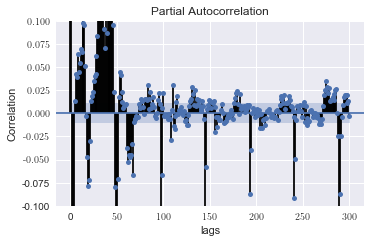

In [10]:
plt.style.available
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=set_size(398))
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)
plot_pacf(train.energy, lags=300, ax = ax)
plt.ylim(-0.1, 0.1)
plt.ylabel('Correlation')
plt.xlabel('lags')
plt.show()

In [14]:
fig.savefig('../figures/london/london_pacf.png', dpi= 300,
            format='png', bbox_inches='tight')

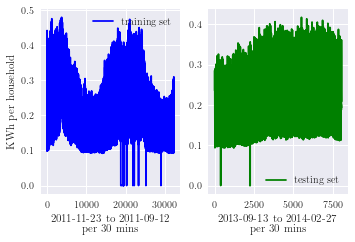

In [207]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = set_size(398))
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)
ax1.set_xlabel('2011-11-23 to 2011-09-12\n per 30 mins')
ax1.set_ylabel('KWh per household')
ax2.set_xlabel('2013-09-13 to 2014-02-27\n per 30 mins')
ax1.plot((train.energy/train.LCLid).to_numpy(),'b-', label='training set')
ax2.plot((test.energy/test.LCLid).to_numpy(),'g-', label = 'testing set')
ax1.legend()
ax2.legend()
fig.savefig('../figures/london/train_test.png', dpi= 300,
            format='png', bbox_inches='tight')

In [210]:
train = extract_dmhq(train)
test = extract_dmhq(test)

In [ ]:
## Deployment grew overtime
train.energy = train.energy/train.LCLid
train.drop(['LCLid'], axis = 1, inplace=True)
test.energy = test.energy/test.LCLid
test.drop(['LCLid'], axis = 1, inplace=True)


### Creat lag ahead scenarios

In [216]:
# normal multioutput
cols = train.columns[8:8]
ftrain, ttrain = feature_target_construct(train, 300, 96, 0, 0, cols, 2,
                                          wd_on = True, d_on = True,
                                          m_on = True, h_on = True, q_on = True)

ftest, ttest = feature_target_construct(test, 300, 96, 0, 0, cols, 2, 
                                        wd_on = True, d_on = True,
                                        m_on = True, h_on = True, q_on = True)


In [217]:
feature_list = list(ftrain.columns)

### Seeking outliers

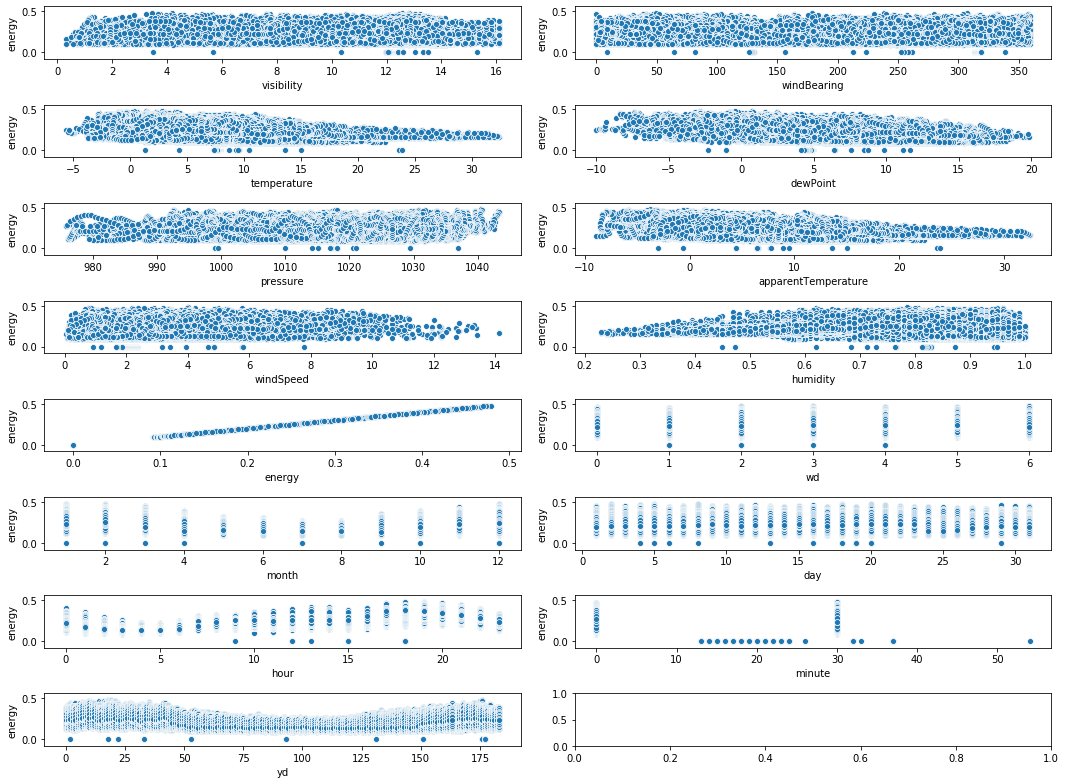

In [41]:
scatter_plot(train)

### Distribution

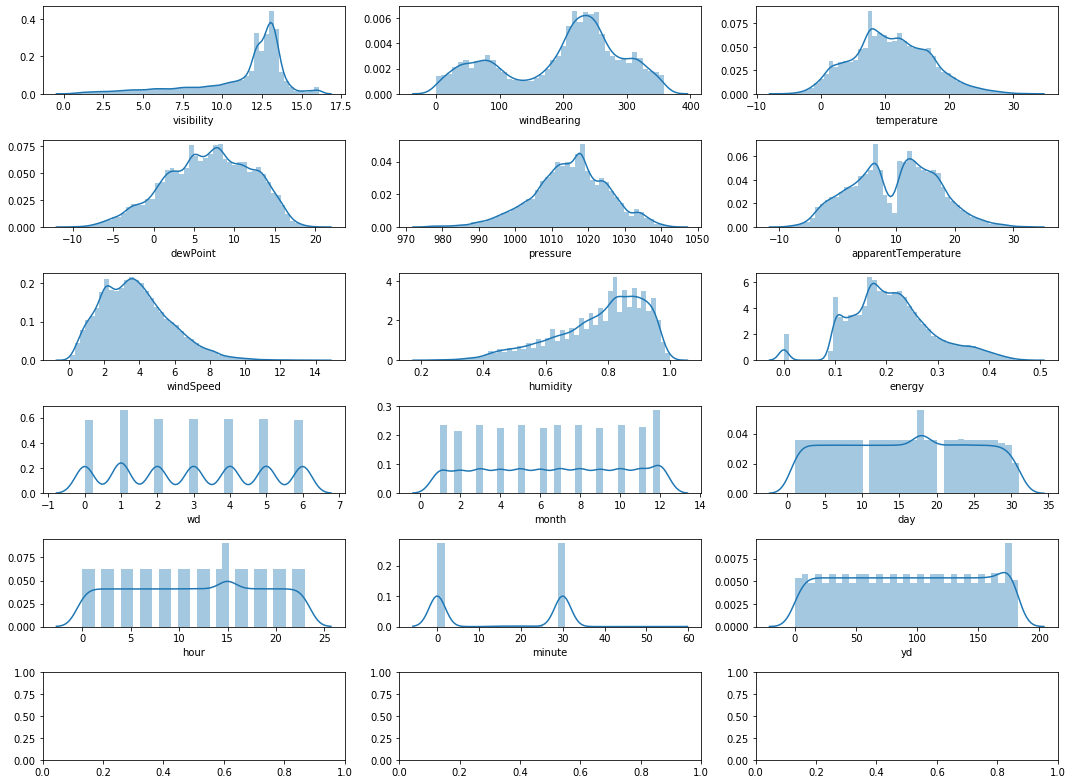

In [42]:
distri_plot(train)

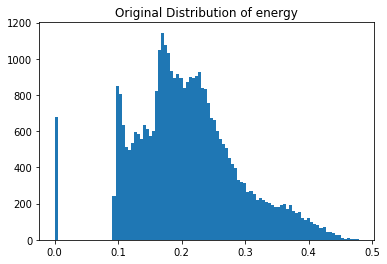

In [43]:
plt.hist(train['energy'], bins=100)
plt.title('Original Distribution of energy')
plt.show()

### Feature Selection: Tree-Based(support multioutput)

In [218]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.feature_selection import SelectFromModel


%time reg = RandomTreesEmbedding(max_depth=2).fit(ftrain)
#model = SelectFromModel(reg, prefit=True)
#cols = model.get_support(indices=True)
#mt_feature = model.transform(ftrain)

CPU times: user 364 ms, sys: 85 ms, total: 449 ms
Wall time: 451 ms


In [219]:
# Get numerical feature importances
importances = list(reg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: energy1(t-218)       Importance: 0.019
Variable: energy1(t-12)        Importance: 0.019
Variable: energy1(t-1)         Importance: 0.019
Variable: energy1(t-194)       Importance: 0.018
Variable: energy1(t-20)        Importance: 0.018
Variable: energy1(t-266)       Importance: 0.017
Variable: energy1(t-103)       Importance: 0.017
Variable: energy1(t-156)       Importance: 0.015
Variable: energy1(t-200)       Importance: 0.014
Variable: energy1(t-284)       Importance: 0.013
Variable: energy1(t-240)       Importance: 0.013
Variable: energy1(t-139)       Importance: 0.013
Variable: energy1(t-137)       Importance: 0.013
Variable: energy1(t-134)       Importance: 0.013
Variable: energy1(t-106)       Importance: 0.013
Variable: energy1(t-272)       Importance: 0.012
Variable: energy1(t-244)       Importance: 0.012
Variable: energy1(t-178)       Importance: 0.012
Variable: energy1(t-163)       Importance: 0.012
Variable: energy1(t-53)        Importance: 0.012
Variable: energy1(t-

CPU times: user 69 µs, sys: 0 ns, total: 69 µs
Wall time: 72.2 µs
CPU times: user 40 µs, sys: 1e+03 ns, total: 41 µs
Wall time: 42 µs


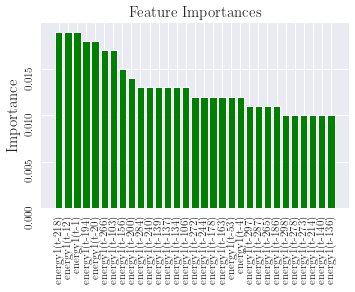

In [244]:
# important features
%time score = [i[1] for i in feature_importances if i[1] >= 0.010]
%time picked_features = [i[0] for i in feature_importances if i[1] >= 0.010]
# list of x locations for plotting
x_values = list(range(len(score)))
# Make a bar chart
fig = plt.figure(figsize=set_size(398))
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)
plt.bar(x_values, score, orientation = 'vertical', color = 'g', edgecolor = 'w', linewidth = 1)
# Tick labels for x axis
plt.xticks(x_values, picked_features, rotation=90, fontsize = 11)
plt.yticks(rotation='vertical', fontsize = 11)
# Axis labels and title
plt.ylabel('Importance',**font); 
plt.title('Feature Importances ',**font)
plt.yticks(arange(0,0.02,0.005))
fig.savefig('../figures/london/rfe_feature_importance.png', dpi= 300,
            format='png', bbox_inches='tight')

In [140]:
pftrain = ftrain[picked_features]
pftest = ftest[picked_features]
#pftrain = ftrain
#pftest = ftest

## Ridge Regression

In [253]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, make_scorer
r2 = make_scorer(score_func=r2_score)
rr = RidgeCV(alphas=arange(10,100,1), fit_intercept=True,cv = TimeSeriesSplit(n_splits = 5), scoring = r2).fit(pftrain, ttrain)
rr.score(pftrain, ttrain)

//miniconda3/envs/tpot/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.8652440008183365

In [254]:
ypred_rr = rr.predict(pftest)
yhat_rr = rr.predict(pftrain)
get_eval(ttest, ypred_rr)
get_eval(ttrain, yhat_rr)

MSE: 0.0005191200565113143
MAE: 0.016297999466446448
r2_score: 0.9142851595909562
MSE: 0.0008955256968862634
MAE: 0.018315997834717105
r2_score: 0.8652440008183365


In [255]:
r2_list_rr = []
for i in range(ttest.shape[0]):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy())
    p_y = np.transpose(ypred_rr[i,:])
    r2 = r2_score(o_y, p_y)
    r2_list_rr.append(r2)

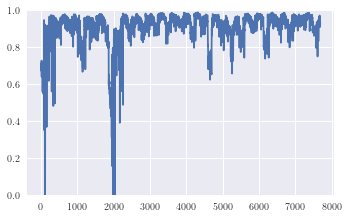

In [262]:
fig = plt.figure(figsize = set_size(398))
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)
plt.ylim(0)
plt.plot(r2_list_rr)

## KNN Regression


In [153]:
from sklearn.metrics import make_scorer
def quantile_loss(y_true, y_pred, q):
    e = y_true - y_pred
    return np.mean(np.maximum(e*q, e*(q-1)))

qloss_05 = make_scorer(quantile_loss, 
                       greater_is_better=False, 
                       needs_proba=False,
                       needs_threshold=False, q = 0.05)

qloss_95 = make_scorer(quantile_loss, 
                       greater_is_better=False, 
                       needs_proba=False,
                       needs_threshold=False, q = 0.95)

In [162]:
from sklearn.neighbors import KNeighborsRegressor
knnr95 = KNeighborsRegressor(n_neighbors=3,
                           weights='distance', 
                           algorithm='auto', 
                           leaf_size=10, 
                           metric=quantile_loss, 
                           metric_params={'q':0.95}, 
                           n_jobs=4)
%time knnr95.fit(pftrain ,ttrain)
%time ypred95 = knnr95.predict(pftest.to_numpy()[0,:].reshape(1, -1))

CPU times: user 3.7 s, sys: 9.77 ms, total: 3.71 s
Wall time: 3.71 s
CPU times: user 210 ms, sys: 9.91 ms, total: 220 ms
Wall time: 236 ms


In [163]:
knnr05 = KNeighborsRegressor(n_neighbors=3,
                           weights='distance', 
                           algorithm='auto', 
                           leaf_size=10, 
                           metric=quantile_loss, 
                           metric_params={'q':0.05}, 
                           n_jobs=4)
knnr05.fit(pftrain ,ttrain)
ypred05 = knnr05.predict(pftest.to_numpy()[0,:].reshape(1, -1))

In [164]:
knnr = KNeighborsRegressor(n_neighbors=3,
                           weights='distance', 
                           algorithm='auto', 
                           leaf_size=10, 
                           metric=quantile_loss, 
                           metric_params={'q':0.5}, 
                           n_jobs=4)
knnr.fit(pftrain ,ttrain)
ypred = knnr.predict(pftest.to_numpy()[0,:].reshape(1, -1))

In [165]:
r2_score(ttest.to_numpy()[0,:].reshape(-1, 1), ypred.reshape(-1, 1))

0.698161093316646

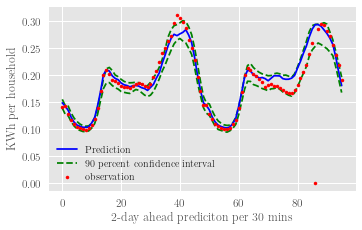

In [344]:
plt.style.available
plt.style.use('seaborn-bright')
fig, ax = plt.subplots(figsize=set_size(398))
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)
ax.plot(ypred95[0,:],'g--')
ax.plot(ypred[0,:],'b-', label = 'Prediction')
ax.plot(ypred05[0,:],'g--', label = '90 percent confidence interval')
ax.plot(ttest.to_numpy()[0,:], 'r.', label = 'observation')
ax.set_xlabel('2-day ahead prediciton per 30 mins')
ax.set_ylabel('KWh per household')
plt.legend()
fig.savefig('../figures/london/knn_90ci.png', dpi= 300,
            format='png', bbox_inches='tight')

In [177]:
ypred_t = knnr.predict(pftest)
get_eval(ttest, ypred_t)

MSE: 0.0003896350107076654
MAE: 0.01275433418989909
r2_score: 0.9356651658095672


In [181]:
r2_list_knn = []
for i in range(ttest.shape[0]):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy())
    p_y = np.transpose(ypred_t[i,:])
    r2 = r2_score(o_y, p_y)
    r2_list_knn.append(r2)

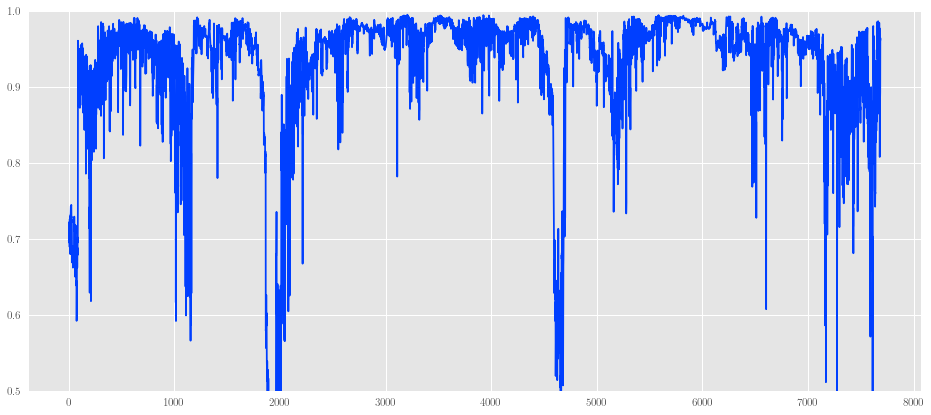

In [342]:
plt.style.available
plt.style.use('seaborn-bright')
fig = plt.figure(figsize=(16,7))
plt.ylim(0.5)
plt.plot(r2_list_knn,'-x')
#plt.plot(r2_list_hg, '--')
#plt.plot(r2_list_rr, '-.')

## Histgradient boost

In [51]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
hgbr = HistGradientBoostingRegressor()
mhgbr = MultiOutputRegressor(hgbr, n_jobs=4)
%time mhgbr.fit(pftrain, ttrain)


CPU times: user 573 ms, sys: 176 ms, total: 748 ms
Wall time: 52.5 s


MultiOutputRegressor(estimator=HistGradientBoostingRegressor(l2_regularization=0.0,
                                                             learning_rate=0.1,
                                                             loss='least_squares',
                                                             max_bins=255,
                                                             max_depth=None,
                                                             max_iter=100,
                                                             max_leaf_nodes=31,
                                                             min_samples_leaf=20,
                                                             n_iter_no_change=None,
                                                             random_state=None,
                                                             scoring=None,
                                                             tol=1e-07,
                                                     

In [52]:
ypred_h = mhgbr.predict(pftest)

In [53]:
get_eval(ttest, ypred_h)

MSE: 0.00034068403647833186
MAE: 0.012533721198123425
r2_score: 0.9437477372519654


In [184]:
r2_list_hg = []
for i in range(ttest.shape[0]):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy())
    p_y = np.transpose(ypred_h[i,:])
    r2 = r2_score(o_y, p_y)
    r2_list_hg.append(r2)

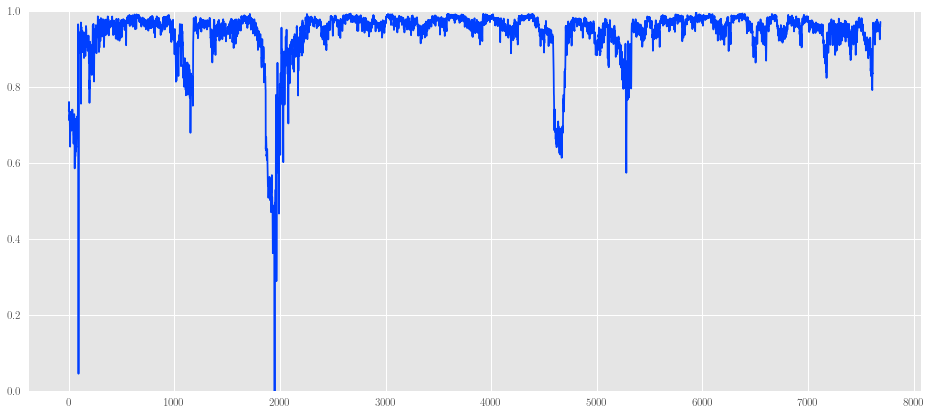

In [343]:
fig = plt.figure(figsize=(16,7))
plt.ylim(0.0)
plt.plot(r2_list_hg)

## Extra Trees Regression

In [56]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=100, n_jobs=4)
X = pftrain
y = ttrain

%time etr.fit(pftrain, ttrain)

CPU times: user 1min 23s, sys: 2.89 s, total: 1min 26s
Wall time: 22.5 s


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=4, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

### Testing set

In [191]:
ypred_etr = etr.predict(pftest)
get_eval(ttest, ypred_etr)

MSE: 0.00030908962393363183
MAE: 0.012130075635329848
r2_score: 0.9489644689022236


In [192]:
r2_list_etr = []
for i in range(ttest.shape[0]):
    o_y = np.transpose(ttest.iloc[i,:].to_numpy())
    p_y = np.transpose(ypred_t[i,:])
    r2 = r2_score(o_y, p_y)
    r2_list_etr.append(r2)

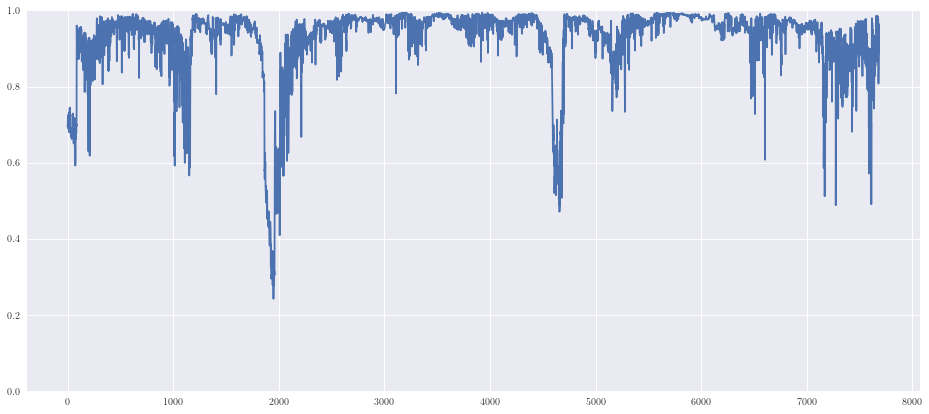

In [264]:
fig = plt.figure(figsize=(16,7))
plt.ylim(0)
plt.plot(r2_list_etr)

### Confidence Interval: Bootstrapping

In [315]:
from sklearn.utils import resample
def bootstrapping_ci(train_X, train_Y, test_X, estimator, n_bootstraps = 100,  p_samples = 0.5):
    """
    Parameters
    ----------
    train_X: pd.DataFrame or numpy.array
        The original features of training set
        
    train_Y: pd.DataFrame or numpy.array
        The original targets of training set
        
    test_X: pd.DataFrame or numpy.array
        The original features of testing set
        
    estimator: sklearn.BaseEstimator
        The estimator to fit and for generating prediction
    
    n_bootstraps: int, default = 100
        The number of resamples taken by bootstrapping
    
    p_samples: float, default = 0.5
        The proportion of random sampling takes from original training data
        
    """
    
    b_x = []
    b_y = []
    prediction_bs = []
    for _ in range(n_bootstraps):
        sample_X ,sample_y = resample(train_X, train_Y, n_samples = int(trian_X.shape[0]*p_samples))
        b_x.append(sample_X)
    b_y.append(sample_y)
    """Now fit the estimators and generate different predictions n_bootstraps times"""
    for i, feature in enumerate(b_x):
        estimator.fit(feature, b_y[i])
        prediction_bs.append(estimator.predict(pftest))
    
    return prediction_bs

**bootstrap prediction:qunatile**

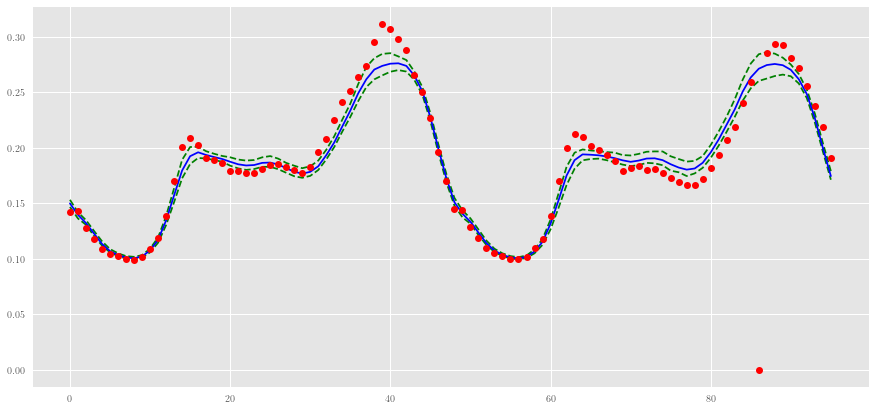

In [309]:
fig = plt.figure(figsize = (15,7))
plt.plot(np.quantile(prediction_bs_etr, 0.95, axis = 0)[0,:],'g--')
plt.plot(np.quantile(prediction_bs_etr, 0.05, axis = 0)[0,:],'g--')
plt.plot(np.quantile(prediction_bs_etr, 0.5, axis = 0)[0,:],'b-')
plt.plot(ttest.to_numpy()[0,:],'ro')

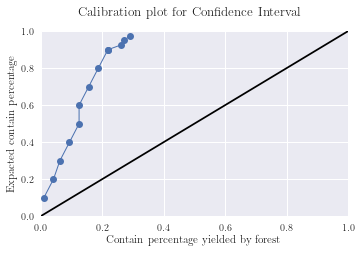

In [334]:
calibration_plot(ttest, prediction_bs_etr, "bootstrap_etr", 0)

### Confidence Interval: group wisedom

In [60]:
## collect predictions of each tree in forest and construct CI
tree_predcition = []
for tree in etr.estimators_:
    tree.fit(pftrain, ttrain)
    tree_predcition.append(tree.predict(pftest))

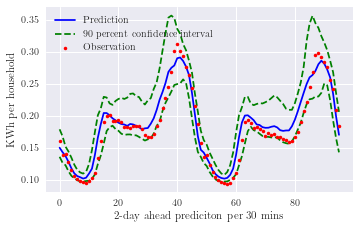

In [296]:
plt.style.available
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=set_size(398))
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 11pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

ax.plot(np.quantile(tree_predcition, 0.95, axis = 0)[192,:],'g--')
ax.plot(np.quantile(tree_predcition, 0.5, axis = 0)[192,:],'b-', label = 'Prediction')
ax.plot(np.quantile(tree_predcition, 0.05, axis = 0)[192,:],'g--', label = '90 percent confidence interval')
ax.plot(ttest.to_numpy()[192,:], 'r.', label = 'Observation')
ax.set_xlabel('2-day ahead prediciton per 30 mins')
ax.set_ylabel('KWh per household')
plt.legend()
fig.savefig('../figures/london/etr_90ci_192.png', dpi= 300,
            format='png', bbox_inches='tight')



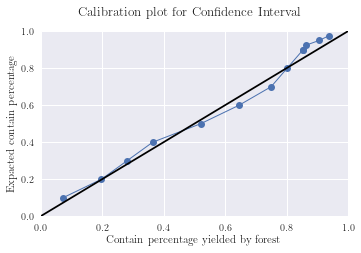

In [333]:
calibration_plot(ttest, tree_predcition, "etr", 1000)

In [63]:
## Take median instead of mean for prediction(could small have improvement)
get_eval(ttest, np.quantile(tree_predcition, 0.5, axis = 0))

MSE: 0.00030266822348658733
MAE: 0.011467843757149265
r2_score: 0.950024742547245


### Confidence Interval static: np.qunatile

In [336]:
def plot_conf_quantile(val_y, val_y_pred, test_y, test_y_pred, n, ci_term):
    median = np.quantile(val_y - val_y_pred, 0.5, axis = 0)
    ub = np.quantile(val_y - val_y_pred, 1- ci_term, axis = 0)
    lb = np.quantile(val_y - val_y_pred, ci_term, axis = 0)

    ypred_t_ub = test_y_pred  + median + ub
    ypred_t_lb = test_y_pred  + median + lb 
    # plot
    fig = plt.figure(figsize=set_size(398))
    tex_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 11pt font in document
        "axes.labelsize": 11,
        "font.size": 11,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    }
    plt.rcParams.update(tex_fonts)
    
    
    plt.style.use('seaborn')
    plt.plot(test_y_pred[n, :].reshape(-1,1), 'gx-',label='Prediction')
    plt.plot(ypred_t_ub[n, :].reshape(-1,1), 'g--', label='{} % upper bond'.format(100-ci_term*100))
    plt.plot(ypred_t_lb[n, :].reshape(-1,1), 'g--', label='{} % lower bond'.format(ci_term*100))
    plt.plot(test_y.iloc[n, :].to_numpy().reshape(-1,1), 'ro', label='Ground truth')
    #plt.fill(np.concatenate([xx, xx[::-1]]),
    #         np.concatenate([y_upper, y_lower[::-1]]),
    #         alpha=.5, fc='b', ec='None', label='90% prediction interval')
    plt.xlabel('hours', **font)
    plt.ylabel('KWh', **font)
    plt.legend(loc='upper left', fontsize = 15)
    plt.show()

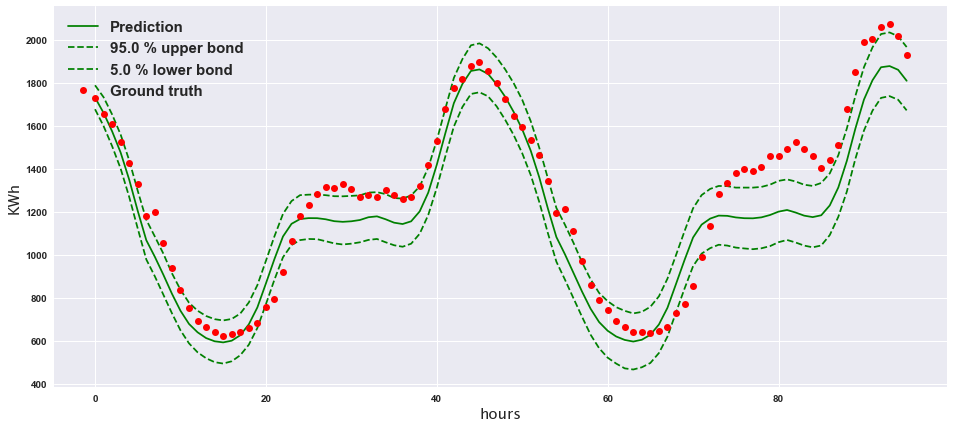

In [22]:
plot_conf_quantile(val_y, ypred, ttest, ypred_t, 185, 0.05)

### Confidence Interval: Static

UnboundLocalError: local variable 'alpha' referenced before assignment

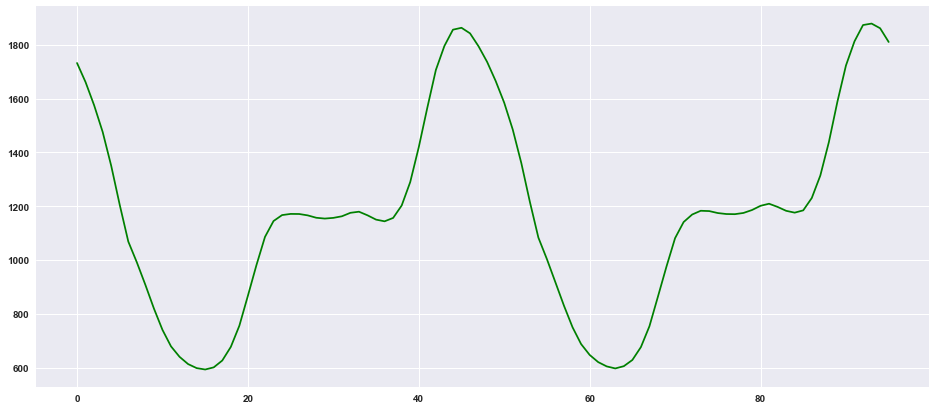

In [23]:
plot_conf_static(val_y, ypred_t, ttest, ypred_t, 185, 0.)

out_of_bound_pecentage 0.27976190476190477


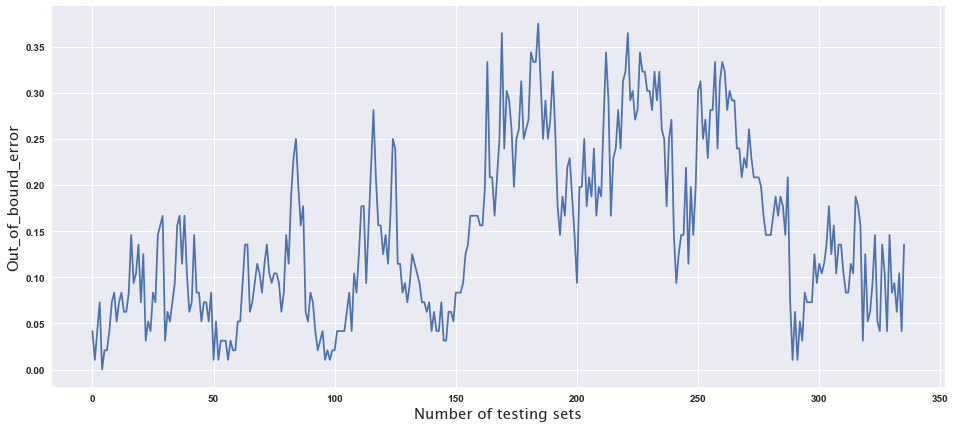

In [189]:
verf_ci_static(1.28, val_y.iloc[:336], ypred[:336], ttest.iloc[:336], ypred_t[:336])

### confidence interval: forest predictors qunatile

In [ ]:
ci_forest(360, 0.1, etr, pftest, ttest)

out_of_bound_pecentage 0.0


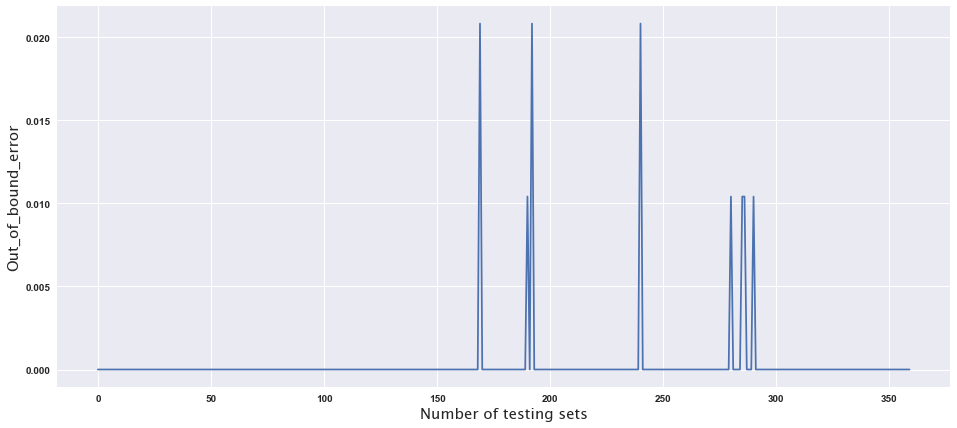

In [195]:
verf_ci_qunatile_forest(0.025, etr, ttest, 360)

### Confidence Interval: dynamic

In [89]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
err_knn = KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=3,
                    weights='uniform')
#scores = cross_val_score(err_knn, val_X, (val_y - ypred), cv = 5, scoring= 'r2', n_jobs = 4)
#print("cross validation scores:", scores)

In [236]:
from sklearn.ensemble import ExtraTreesRegressor
err_etr = ExtraTreesRegressor()
scores = cross_val_score(err_etr, val_X, (val_y - ypred)**2, cv = 5, scoring= 'r2', n_jobs = 4)
print("cross validation scores:", scores)

cross validation scores: [ 0.14660699 -0.58172587 -3.25540463 -0.24779615 -2.6530114 ]


In [122]:
from sklearn.ensemble import RandomForestRegressor
err_rfr = RandomForestRegressor()
scores = cross_val_score(err_rfr, val_X, (val_y - ypred)**2, cv = 5, scoring= 'r2', n_jobs = 4)
print("cross validation scores:", scores)

cross validation scores: [ 0.23419848  0.33726216  0.14079612 -0.29860155 -0.03461351]


In [90]:
err_knn.fit(val_X, (val_y - ypred)**2)
perrorsq = err_knn.predict(pftest)

In [276]:
err_etr.fit(val_X, (val_y - ypred)**2)
perrorsq = err_etr.predict(pftest)

In [279]:
err_rfr.fit(val_X, (val_y - ypred)**2)
perrorsq = err_rfr.predict(pftest)

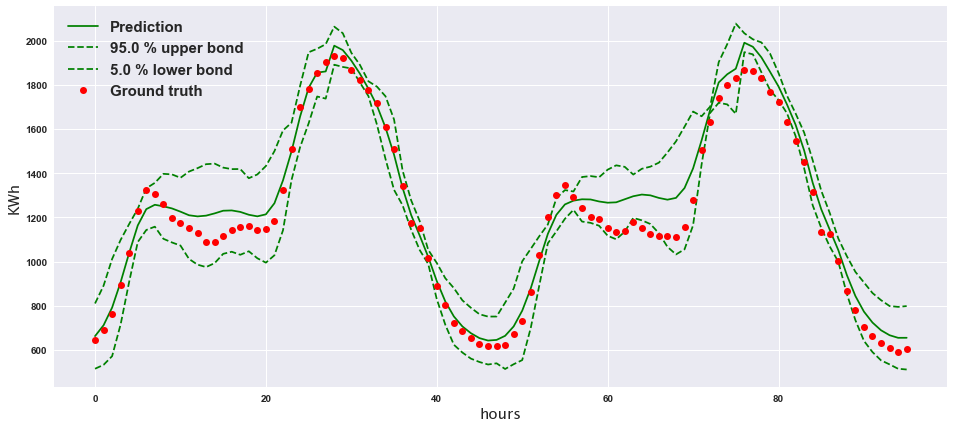

In [338]:
plot_conf_dynamic(perrorsq, ttest, ypred_t, 10, 1.645)

out_of_bound_pecentage 0.15


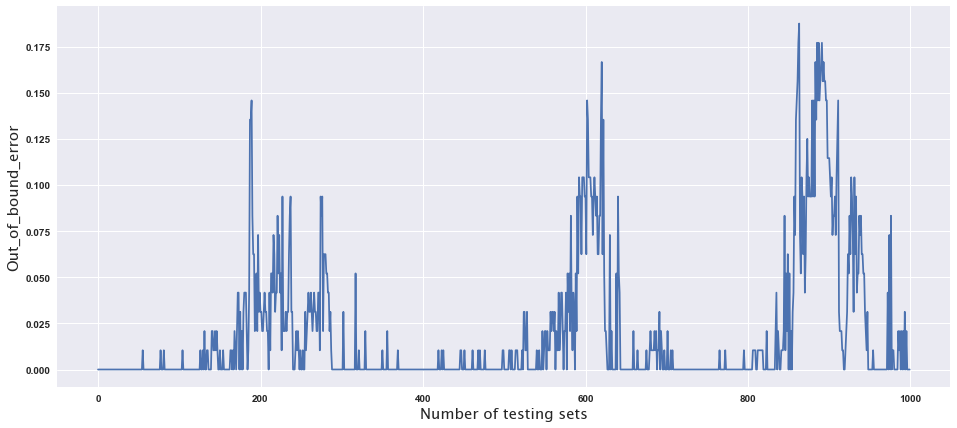

In [93]:
verf_ci_dynamic(1.96, np.sqrt(np.std(perrorsq, axis = 0)), ttest.iloc[:1000,:], ypred_t[:1000,:])

### Random Forest Regression

In [345]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
rfr = RandomForestRegressor(n_estimators=100, n_jobs=3)
%time rfr.fit(pftrain, ttrain)


CPU times: user 4min 51s, sys: 4.18 s, total: 4min 55s
Wall time: 1min 40s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=3, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [346]:
ypred_rfr = rfr.predict(pftest)
get_eval(ttest, ypred_rfr)

MSE: 0.0003172259378283574
MAE: 0.012302906969907719
r2_score: 0.947621036225607


### Confidence interval: Group Wisedom

In [ ]:
## collect predictions of each tree in forest and construct CI
rfr_predcition = []
for tree in rfr.estimators_:
    tree.fit(pftrain, ttrain)
    rfr_predcition.append(tree.predict(pftest))

### Confidence interval:static

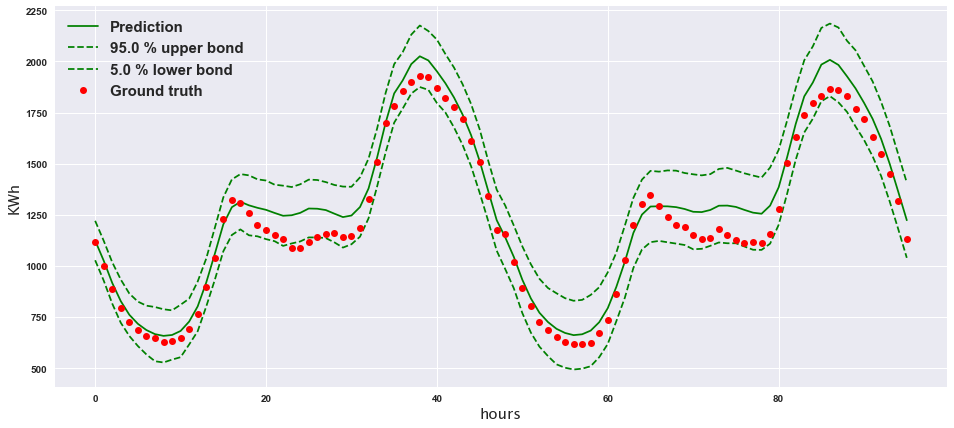

In [562]:
plot_conf_static(val_y, ypred, ttest, ypred_t, 0, 1.645)

### Confidence interval:dynamic

**KNN**

In [563]:
err_knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')
err_knn.fit(val_X, (val_y - ypred)**2)
err_knn.score(val_X, (val_y - ypred)**2)

//miniconda3/envs/tpot/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.5187379760149411

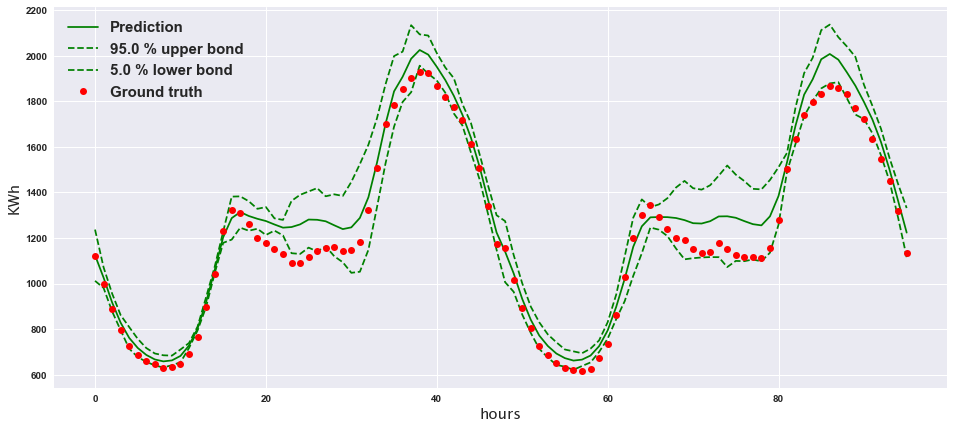

In [564]:
yhat = err_knn.predict(pftest.iloc[0,:].to_numpy().reshape(1,-1))
plot_conf_dynamic(yhat, ttest, ypred_t, 0, 1.645)

**ExtraTrees**


In [565]:
err_etr = ExtraTreesRegressor()
err_etr.fit(val_X, (val_y - ypred)**2)
err_etr.score(val_X, (val_y - ypred)**2)

//miniconda3/envs/tpot/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


1.0

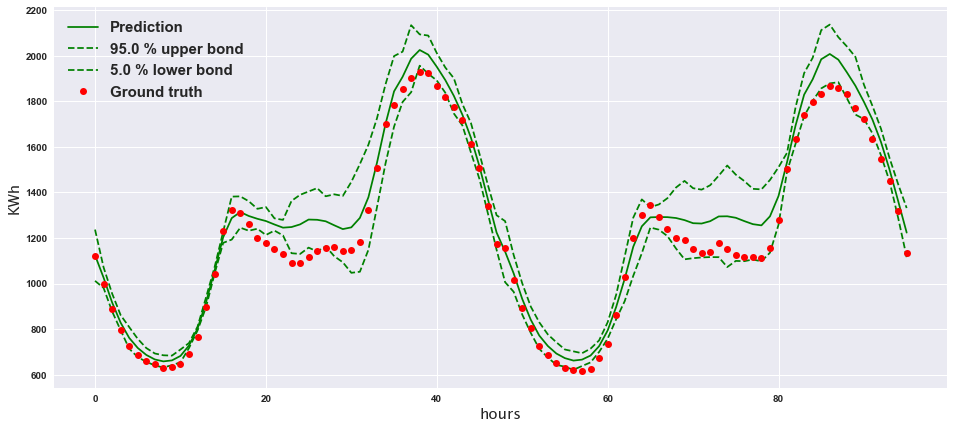

In [567]:
yhat = err_knn.predict(pftest.iloc[0,:].to_numpy().reshape(1,-1))
plot_conf_dynamic(yhat, ttest, ypred_t, 0, 1.645)



### Xgboost: Manual

In [500]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

X = pftrain
y = ttrain

xgbr = xgb.XGBRegressor(max_depth=10, njobs= 4)
mr = MultiOutputRegressor(xgbr, n_jobs = 4)
mr.fit(train_X, train_y)
#rc = MultiOutputRegressor(xgbr, cv = 5, random_state = 123)
#rc.fit(train_X, train_y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=10, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, njobs=4, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                        

### Result evaluation: validation set

In [513]:
yhat = mr.predict(val_X)

In [502]:
get_eval(val_y, yhat)

MSE: 7765.100654935687
MAE: 44.55453092189882
r2_score: 0.9712537126596072


### Result evaluation: test set

In [503]:
ypred = mr.predict(pftest)

In [504]:
get_eval(ttest, ypred)

MSE: 10175.073762555183
MAE: 70.17073013698152
r2_score: 0.935999498972345


### Confidnece interval: Static

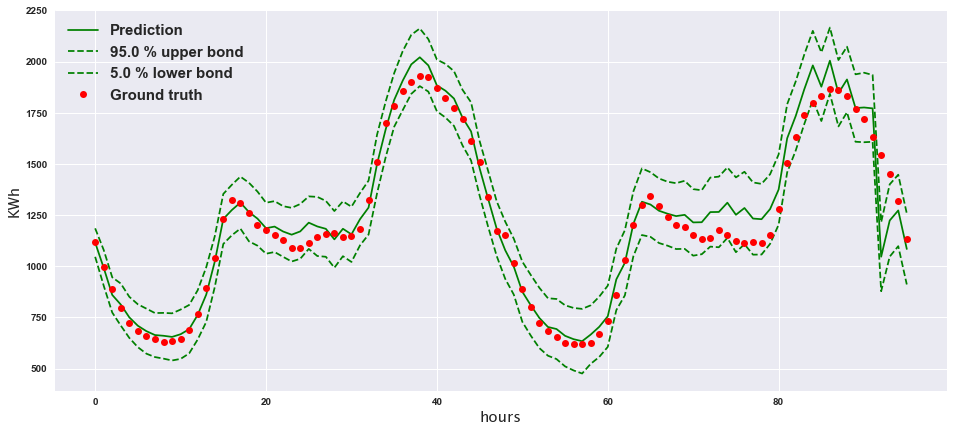

In [508]:
plot_conf_static(val_y, yhat, ttest, ypred, 0, 1.645)

### Confidence Interval: dynamic

In [599]:
from sklearn.model_selection import cross_val_score, cross_val_predict
err_knn = KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=3,
                    weights='uniform')
scores = cross_val_score(err_knn, val_X, (val_y - yhat)**2, cv = 10, scoring= 'r2' ,n_jobs = 4)
print("cross validation scores:", scores)

cross validation scores: [0.94346122 0.94695128 0.94615383 0.94496561 0.94323953 0.94689917
 0.92899007 0.9450479  0.94872416 0.94161291]


In [600]:
err_etr = ExtraTreesRegressor()
etr_scores = cross_val_score(err_etr, val_X, (val_y - yhat)**2, cv = 5, scoring= 'r2' ,n_jobs = 4)
print("cv r2_scores:", etr_scores)
predictions = cross_val_predict(err_etr, val_x, (val_y - yhat)**2)

//miniconda3/envs/tpot/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


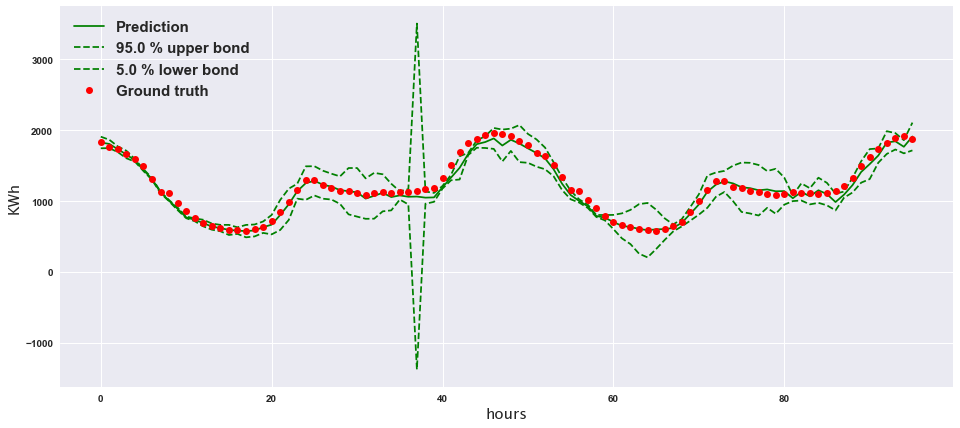

In [544]:
yhat = err_knn.predict(pftest.iloc[0,:].to_numpy().reshape(1,-1))
plot_conf_dynamic(yhat, ttest, ypred, 1000, 1.645)

### LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             14200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 96)             4896      
Total params: 19,096
Trainable params: 19,096
Non-trainable params: 0
_________________________________________________________________

Epoch 1/50
 - 3s - loss: 907187.9891
Epoch 2/50
 - 2s - loss: 582957.2942
Epoch 3/50
 - 2s - loss: 340729.4832
Epoch 4/50
 - 2s - loss: 268444.2695
Epoch 5/50
 - 2s - loss: 238410.4348
Epoch 6/50
 - 2s - loss: 212033.8502
Epoch 7/50
 - 2s - loss: 188070.4098
Epoch 8/50
 - 2s - loss: 167425.9583
Epoch 9/50
 - 2s - loss: 150808.0975
Epoch 10/50
 - 2s - loss: 138048.8542
Epoch 11/50
 - 2s - loss: 127697.5308
Epoch 12/50
 - 2s - loss: 118425.3864
Epoch 13/50
 - 2s - loss: 109641.9108
Epoch 14/50
 - 2s - loss: 

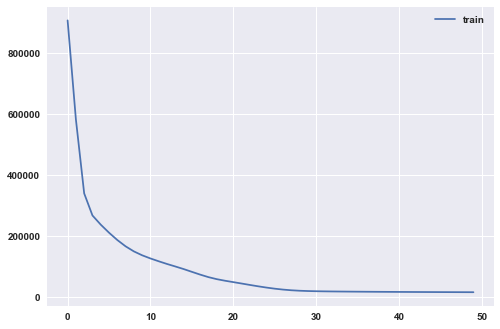

In [418]:
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

train_X, val_X, train_y, val_y = train_test_split(pftrain, ttrain, train_size = 0.7, test_size = 0.3)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.to_numpy().reshape((train_y.shape[0],1, train_y.shape[1]))

# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(96)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

### Validation sets

**Metrics**


In [419]:
yhat = model.predict(val_X.reshape(val_X.shape[0], 1, val_X.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

In [420]:
get_eval(val_y, yhat)

MSE: 18339.820647197208
MAE: 74.85561810425645
r2_score: 0.9317110281105421


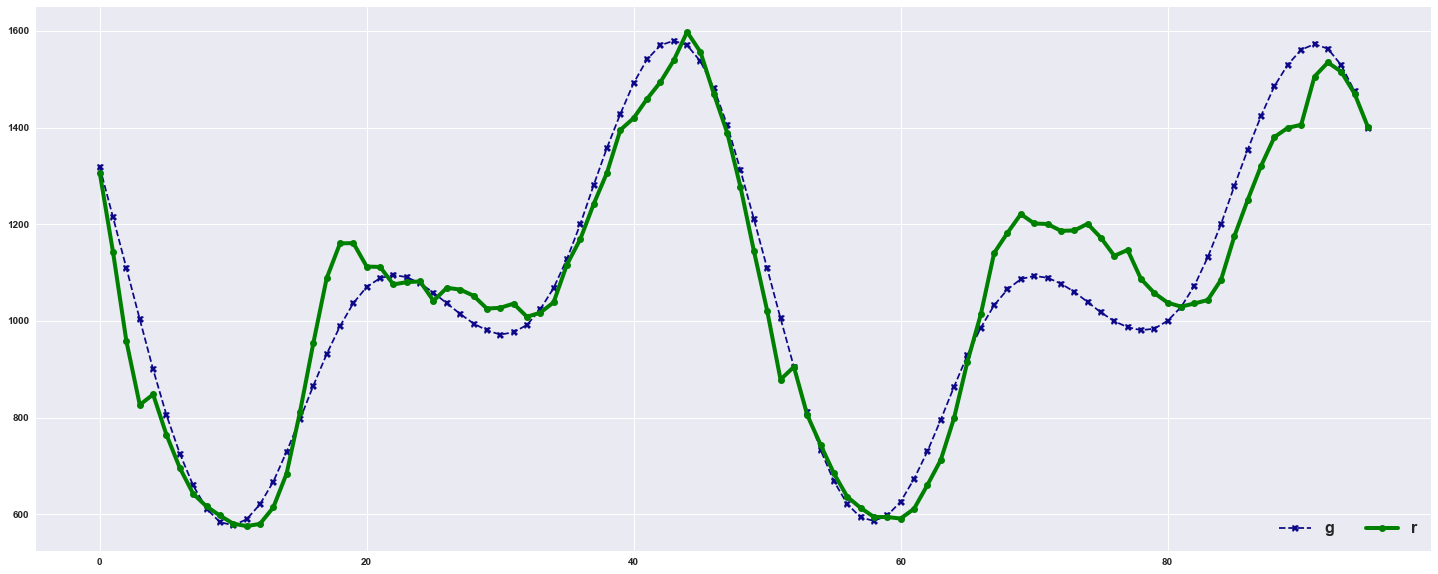

In [421]:
real = val_y.to_numpy()
guess = yhat
real = real[1:2,:96]
guess = guess[1:2,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()

### Testing sets

In [425]:
test_x = pftest
yhat = model.predict(test_x.reshape(test_x.shape[0], 1, test_x.shape[1]))
yhat = yhat.reshape(yhat.shape[0], yhat.shape[2])

**Metrics**

In [426]:
test_y = ttest
get_eval(test_y.iloc[:1,:].to_numpy().reshape(-1,1), yhat[:1,:].reshape(-1,1))

MSE: 6897.72371174048
MAE: 63.57475920141602
r2_score: 0.9531105547594014


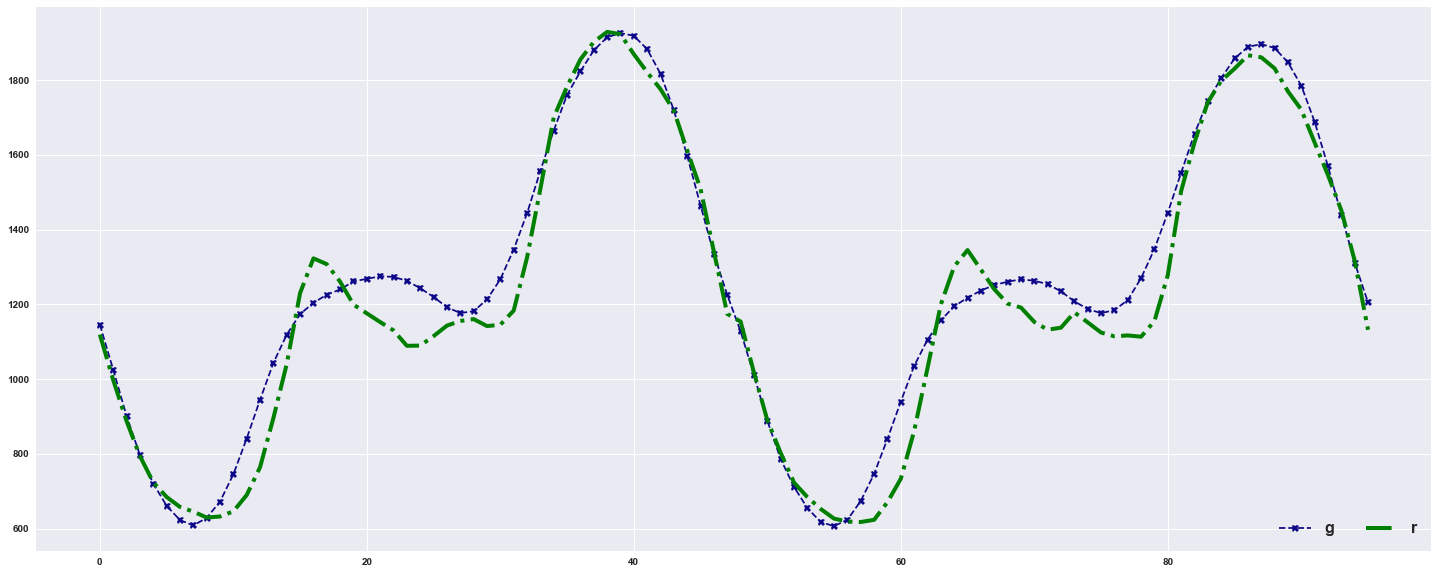

In [427]:
real = test_y.to_numpy()
guess = yhat
real = real[0:1,:96]
guess = guess[0:1,:96]
rpdf = plot_df(real,"r")
gpdf = plot_df(guess,"g")
    
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='--X',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-.',legend = True, ax = ax,lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6, prop={'size': 16})
    
plt.show()